In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
import warnings

#Loading data and looking first five row
df=pd.read_csv("dataset.csv")
df.head()

,feature_1,feature_2,feature_3,feature_4,isVirus
0,-0.233467,0.308799,2.484015,1.732721,False
1,1.519003,1.238482,3.344450,0.783744,False
2,0.400640,1.916748,3.291096,-0.918519,False
3,-1.616474,0.209703,1.461544,-0.291837,False
4,1.480515,5.299829,2.640670,1.867559,True


In [3]:
# Looking at the statistical properties of numerical data
df.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
feature_1,1897.0,0.814404,1.729538,-2.285499,-1.681182,-1.147612,-0.556433,0.084789,2.270955,3.937620,4.883672,5.929096
feature_2,1899.0,1.795843,1.605611,-7.363119,-2.870160,-1.063739,0.975148,1.881904,2.840511,4.203800,5.136615,7.549658
feature_3,1893.0,2.621096,1.474973,-5.363119,-0.933726,0.452311,1.671905,2.499623,3.470200,5.079245,6.553306,9.549658
feature_4,1897.0,0.807499,1.768597,-3.006499,-1.797488,-1.184950,-0.563357,0.021857,2.319822,4.040934,4.926657,5.759355


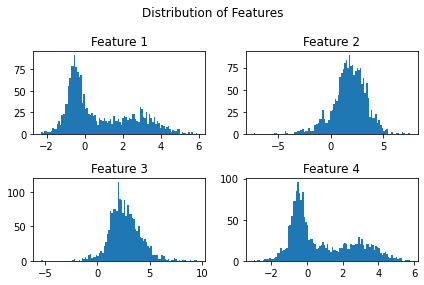

In [8]:
# Plotting distributions of features
fig, axs=plt.subplots(2, 2)
fig.suptitle("Distribution of Features")

axs[0,0].hist(df["feature_1"],bins=100)
axs[0, 0].set_title("Feature 1")

axs[0,1].hist(df["feature_2"],bins=100)
axs[0, 1].set_title("Feature 2")

axs[1,0].hist(df["feature_3"],bins=100)
axs[1, 0].set_title("Feature 3")

axs[1,1].hist(df["feature_4"],bins=100)
axs[1, 1].set_title("Feature 4")
plt.tight_layout()
plt.show()

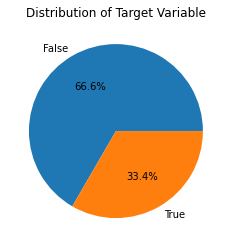

In [5]:
#Ploting distribution of target variable
plt.pie(df["isVirus"].value_counts(), labels=df["isVirus"].unique(),autopct="%1.1f%%")
plt.title("Distribution of Target Variable")
plt.show()

In [9]:
#Calculating average and median of the variables in the target variable breakdown
df.groupby("isVirus").agg({"feature_1":["mean","median"],
                           "feature_2":["mean","median"],
                           "feature_3":["mean","median"],
                           "feature_4":["mean","median"]})

feature_1           feature_2           feature_3           feature_4  \
             mean    median      mean    median      mean    median      mean   
isVirus                                                                         
False    1.352241  1.386102  2.107789  2.295084  2.740450  2.634945  1.354239   
True    -0.262122 -0.404237  1.173426  1.311053  2.380677  2.233818 -0.286848   

                   
           median  
isVirus            
False    1.327783  
True    -0.405365

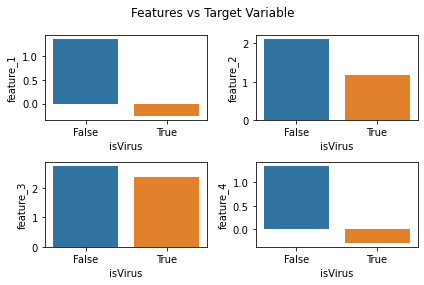

In [10]:
#Plotting target variable vs features
fig, axs=plt.subplots(2, 2)
fig.suptitle("Features vs Target Variable")

sns.barplot(data=df, x="isVirus", y="feature_1", ax=axs[0, 0], ci=False)

sns.barplot(data=df, x="isVirus", y="feature_2", ax=axs[0, 1],ci=False)

sns.barplot(data=df, x="isVirus", y="feature_3", ax=axs[1, 0],ci=False)

sns.barplot(data=df, x="isVirus", y="feature_4", ax=axs[1, 1],ci=False)

plt.tight_layout()
plt.show()

In [11]:
# Checking missing values
print(df.isnull().sum())
print(f"Proportion of missing values ​​in the entire data : {(df.isnull().sum().sum()/len(df))*100}%")
#20.5 percent is too high to drop so we should impute it

feature_1    102
feature_2    100
feature_3    106
feature_4    102
isVirus        0
dtype: int64
Proportion of missing values ​​in the entire data : 20.51025512756378%


In [12]:
# Imputting missing values with the mean of its label

#iterate over the columns name
for col in [col for col in df.columns if col!="isVirus"]:
  #find index of rows which contain missing values in that column
  missing_indices=df[df[col].isnull()].index

  #iterate over these indices and impute missing values with the mean of its class
  for index in missing_indices:
    target_value=df.at[index, "isVirus"]
    mean_value =df[df["isVirus"]==target_value][col].mean()
    df.at[index, col]=mean_value
df.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
isVirus      0
dtype: int64

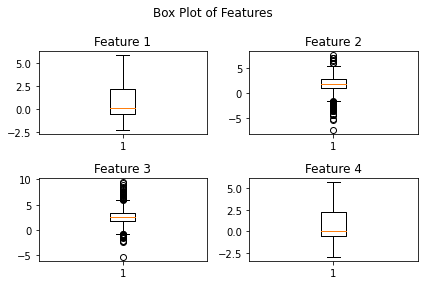

In [13]:
#checking outliers in features bu plotting box plot
fig, axs=plt.subplots(2, 2)
fig.suptitle("Box Plot of Features")

axs[0,0].boxplot(df["feature_1"])
axs[0, 0].set_title("Feature 1")

axs[0,1].boxplot(df["feature_2"])
axs[0, 1].set_title("Feature 2")

axs[1,0].boxplot(df["feature_3"])
axs[1, 0].set_title("Feature 3")

axs[1,1].boxplot(df["feature_4"])
axs[1, 1].set_title("Feature 4")

plt.tight_layout()
plt.show()




In [14]:
#There are outliers in feature_2 and feature_3
#Imputing outliers with the upper and lower limit

for col in [col for col in df.columns if col!="isVirus"]:
  quantile_25=df[col].quantile(0.25)
  quantile_75=df[col].quantile(0.75)
  iqr=quantile_75-quantile_25
  upper_limit=quantile_75+1.5*iqr
  lower_limit=quantile_25-1.5*iqr
  number_of_outliers=len(df[(df[col]>upper_limit)|(df[col]<lower_limit)])
  print(f"Number of outliers in column {col}: {number_of_outliers}")
  if number_of_outliers>0:
    df.loc[df[col]<lower_limit,col]=lower_limit
    df.loc[df[col]>upper_limit,col]=upper_limit
    number_of_outliers=len(df[(df[col]>upper_limit)|(df[col]<lower_limit)])
    print("After replacing them with upper and lower limits")
    print(f"Number of outliers in column {col}: {number_of_outliers}")
    print("************************************************************")
    continue
  print("************************************************************")

Number of outliers in column feature_1: 0
************************************************************
Number of outliers in column feature_2: 64
After replacing them with upper and lower limits
Number of outliers in column feature_2: 0
************************************************************
Number of outliers in column feature_3: 62
After replacing them with upper and lower limits
Number of outliers in column feature_3: 0
************************************************************
Number of outliers in column feature_4: 0
************************************************************


In [15]:
#Splitting data into train set and test set
X=df.drop("isVirus",axis=1)
y=df[["isVirus"]]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)


In [16]:
# Oversampling to remove imbalance in the data set
sm=SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [17]:
#Checking new distribution of target variables
y_train_resampled.value_counts()

isVirus
False      1065
True       1065
dtype: int64

In [18]:
#Scaling our data with standard scaler
scaler=StandardScaler()
X_train_resampled=scaler.fit_transform(X_train_resampled)
X_test=scaler.transform(X_test)

In [19]:
#Training and evaluating different classifying models
warnings.filterwarnings("ignore")
models=[("RF",RandomForestClassifier(random_state=42)),
        ("LGBM",LGBMClassifier(random_state=42,verbose=0)),
        ("XGB",XGBClassifier(random_state=42)),
        ("GB",GradientBoostingClassifier(random_state=42)),
        ("ADA",AdaBoostClassifier(random_state=42)),
        ("KNeighbors",KNeighborsClassifier(n_neighbors=5)),
        ("LR",LogisticRegression(random_state=42))]
for name,model in models:
  model.fit(X_train_resampled,y_train_resampled)
  y_pred=model.predict(X_test)
  print(f"***********************{name}*********************************")
  #Since our dataset is inbalanced, accuracy score can be missleading.
  #So we also should consider F1 Recall and Precision scores
  print(f"Accuracy score of {name}: {accuracy_score(y_test,y_pred)}")
  print(f"F1 score of {name}: {f1_score(y_test,y_pred)}")
  print(f"Recall score of {name}: {recall_score(y_test,y_pred)}")
  print(f"Precision score of {name}: {precision_score(y_test,y_pred)}")



***********************RF*********************************
Accuracy score of RF: 0.875
F1 score of RF: 0.8046875
Recall score of RF: 0.7744360902255639
Precision score of RF: 0.8373983739837398
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
***********************LGBM*********************************
Accuracy score of LGBM: 0.88
F1 score of LGBM: 0.816793893129771
Recall score of LGBM: 0.8045112781954887
Precision score of LGBM: 0.8294573643410853
***********************XGB*********************************
Accuracy score of XGB: 0.87
F1 score of XGB: 0.8
Recall score of XGB: 0.7819548872180451
Precision score of XGB: 0.8188976377952756
***********************GB*********************************
Accuracy score of GB: 0.865
F1 score of GB: 0.8014705882352942
Recall score of GB: 0.8195488721804511
Precision sco

In [21]:
#Tuning the hyperparameter of the two models
#RandomForest
rf_model = RandomForestClassifier()

rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=True).fit(X_train_resampled, y_train_resampled)
print(rf_best_grid.best_params_)
print(rf_best_grid.best_score_)
rf_final = rf_model.set_params(**rf_best_grid.best_params_).fit(X_train_resampled, y_train_resampled)
y_pred=rf_final.predict(X_test)
print(f"Accuracy score of RF_final: {accuracy_score(y_test,y_pred)}")
print(f"F1 score of RF_final: {f1_score(y_test,y_pred)}")
print(f"Recall score of RF_final: {recall_score(y_test,y_pred)}")
print(f"Precision score of RF_final: {precision_score(y_test,y_pred)}")


Fitting 3 folds for each of 180 candidates, totalling 540 fits
{'max_depth': None, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.9248826291079811
Accuracy score of RF_final: 0.8875
F1 score of RF_final: 0.8275862068965517
Recall score of RF_final: 0.8120300751879699
Precision score of RF_final: 0.84375


In [22]:
#XGBoost
xgboost_model = XGBClassifier()

xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [5, 8, 12, 15, 20],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=3, n_jobs=-1, verbose=True).fit(X_train_resampled, y_train_resampled)
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X_train_resampled, y_train_resampled)

y_pred=xgboost_final.predict(X_test)
print(f"Accuracy score of XGB_final: {accuracy_score(y_test,y_pred)}")
print(f"F1 score of XGB_final: {f1_score(y_test,y_pred)}")
print(f"Recall score of XGB_final: {recall_score(y_test,y_pred)}")
print(f"Precision score of XGB_final: {precision_score(y_test,y_pred)}")

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Accuracy score of XGB_final: 0.875
F1 score of XGB_final: 0.8091603053435114
Recall score of XGB_final: 0.7969924812030075
Precision score of XGB_final: 0.8217054263565892
